In [13]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [14]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [34]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [35]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [36]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)



(966, 150)
(322, 150)


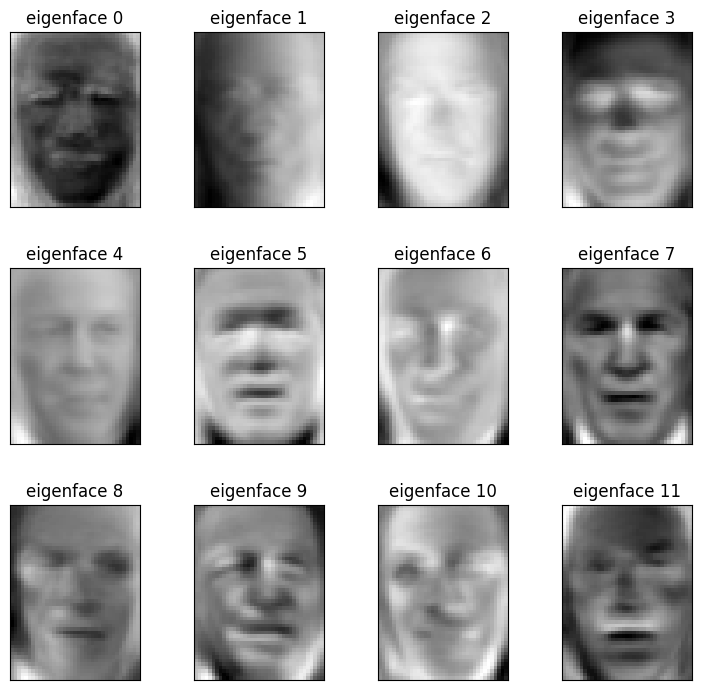

In [37]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


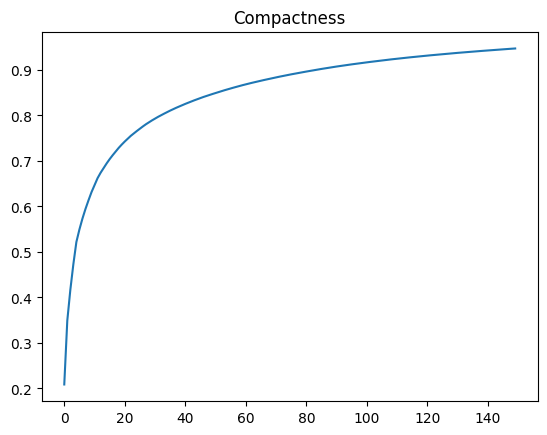

In [19]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 4 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 4 1 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 6 1 3 4 2 6 1 4 1 3 6 4 3 3
 3 2 3 6 1 3 6 3 3 3 3 3 3 3 3 1 5 6 3 3 1 3 1 1 2 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 3 3 3 1 3 3 3 3
 6 1 4 3 1 3 3 3 6 3 3 3 4 5 5 1 3 4 5 1 3 3 3 3 1 1 5 3 3 3 3 5 3 3 3 1 3
 3 3 3 3 2 6 3 2 3 6 3 3 3 3 3 3 2 3 3 5 1 4 2 6 2 3 5 3 3 3 3 3 2 3 3 3 3
 3 1 1 3 3 3 3 3 3 3 3 3 3 1 6 6 3 3 3 4 6 3 3 1 3 3 1 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 6 1 1 3 3 3 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 1
 3 4 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 1 3 3 1 3 3 5 3]
Which Correct: [ True  True False  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

In [22]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [64]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42)#All data is imported in the form on numpyArrays

n_components = 150

#Convert into tf tensort
X_train2 = tf.convert_to_tensor(X_train2, dtype=tf.float64)
X_test2 = tf.convert_to_tensor(X_test2, dtype=tf.float64)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

mean2 = tf.reduce_mean(X_train2, axis = 0 )
X_train2 -= mean2
X_test2 -= mean2

U2, S2, V2 = tf.linalg.svd(X_train2, full_matrices=False)

V2 = tf.transpose(V2)

components2 = V2[:n_components,:]

eigenfaces2 = tf.reshape(components2, (n_components, h, w))

X_transformed2 = tf.matmul(X_train2, tf.transpose(components2))
print(X_transformed.shape)

X_test_transformed2 = tf.matmul(X_test2, tf.transpose(components2))
print(X_test_transformed.shape)

X_transformed_np2 = X_transformed2.numpy()
X_test_transformed_np2 = X_test_transformed2.numpy()
eigenfaces2 = eigenfaces2.numpy()

Num GPUs Available:  1
(966, 150)
(322, 150)


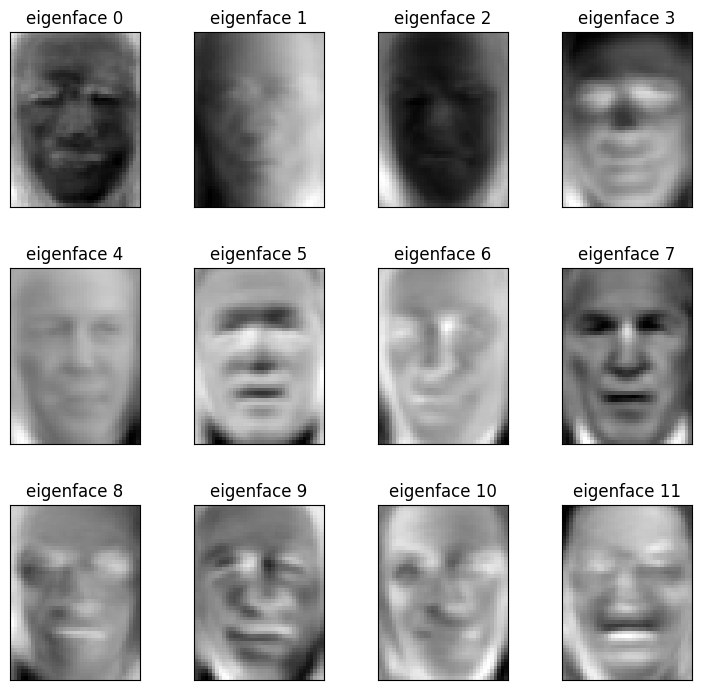

In [65]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces2.shape[0])]
plot_gallery(eigenfaces2, eigenface_titles, h, w)
plt.show()

In [51]:
print("TF")
print(V2)
print("Numpy")
print(V)


TF
tf.Tensor(
[[-8.55606718e-03 -2.31999888e-02  2.43952906e-02 ... -1.97076789e-02
   9.35866493e-03 -2.47201868e-02]
 [-9.70005316e-03 -2.14058320e-02  2.26535431e-02 ...  1.04506433e-02
   1.18860161e-02  2.03661927e-02]
 [-1.20525913e-02 -2.25647016e-02  2.15616038e-02 ...  1.93581077e-02
   2.16102702e-02  9.95790451e-03]
 ...
 [-1.88527459e-02  4.41337484e-02  5.87252119e-02 ...  1.99018432e-03
   2.14294130e-02  3.43742075e-03]
 [-1.74056685e-02  4.33244029e-02  5.15526902e-02 ... -6.37447364e-03
  -1.98399773e-02 -7.46948740e-03]
 [-1.60530791e-02  4.22489312e-02  4.77714350e-02 ... -9.98287718e-04
  -9.00535885e-05 -2.18132529e-02]], shape=(1850, 966), dtype=float64)
Numpy
[[-8.5560670e-03 -9.7000534e-03 -1.2052591e-02 ... -1.8852746e-02
  -1.7405668e-02 -1.6053079e-02]
 [-2.3199989e-02 -2.1405833e-02 -2.2564702e-02 ...  4.4133749e-02
   4.3324403e-02  4.2248931e-02]
 [-2.4395291e-02 -2.2653542e-02 -2.1561604e-02 ... -5.8725212e-02
  -5.1552691e-02 -4.7771435e-02]
 ...
 [-1.97

In [63]:
print("TF V")
print(V2)
print("Numpy V")
print(V)
print(V.shape)
print("TF components")
print(components2)
print("Numpy components")
print(components)
print(components.shape)

TF V
tf.Tensor(
[[-8.55606718e-03 -9.70005316e-03 -1.20525913e-02 ... -1.88527459e-02
  -1.74056685e-02 -1.60530791e-02]
 [-2.31999888e-02 -2.14058320e-02 -2.25647016e-02 ...  4.41337484e-02
   4.33244029e-02  4.22489312e-02]
 [ 2.43952906e-02  2.26535431e-02  2.15616038e-02 ...  5.87252119e-02
   5.15526902e-02  4.77714350e-02]
 ...
 [-1.97076789e-02  1.04506433e-02  1.93581077e-02 ...  1.99018432e-03
  -6.37447364e-03 -9.98287718e-04]
 [ 9.35866493e-03  1.18860161e-02  2.16102702e-02 ...  2.14294130e-02
  -1.98399773e-02 -9.00535885e-05]
 [-2.47201868e-02  2.03661927e-02  9.95790451e-03 ...  3.43742075e-03
  -7.46948740e-03 -2.18132529e-02]], shape=(966, 1850), dtype=float64)
Numpy V
[[-8.5560670e-03 -9.7000534e-03 -1.2052591e-02 ... -1.8852746e-02
  -1.7405668e-02 -1.6053079e-02]
 [-2.3199989e-02 -2.1405833e-02 -2.2564702e-02 ...  4.4133749e-02
   4.3324403e-02  4.2248931e-02]
 [-2.4395291e-02 -2.2653542e-02 -2.1561604e-02 ... -5.8725212e-02
  -5.1552691e-02 -4.7771435e-02]
 ...
 [-